In [6]:
import matplotlib.pyplot as plt
import os
import time
import matplotlib
import numpy as np
import pandas as pd

Optimisation in science
<div>
<img src="http://www.jensuhlig.de/Kemm30/KEMM30_007.png" width="600">
</div>

How do you get there? or better,how do you get there without producing a lot of nonsense
Counting parameter. e.g. 10 peaks, each position, width, intensity =30 parameter plus background. So fitting is about intelligence. Think, $\textbf{optimize}$ the smallest amount of parameter starting with a good guess

One parameter optimisation (middle = mu)
<div>
<img src="http://www.jensuhlig.de/Kemm30/error_way.png" width="1000">
</div>

<div>
<img src="http://www.jensuhlig.de/Kemm30/KEMM30_008.jpg" width="900">
</div>

# Functions:

normal Functions that will be used a few times

In [ ]:
def my_function(s):  #this gives the name of the function. The brackets are mandatory (they do not need to contain anything) colon : is mandatory
    print(s) # here needs to be something (what is done in the function) and this needs to be intended
my_function('hello world')

def my_function(s='input to a function'): #with Standard input that is used if you do not give an input
    print(s)
my_function()

def my_function(s=None,a=['get','a','second','input']): #multiple input
    s=1  #inside the function you can use whatever variable you have given, and you can do to it whatever you want. If you have the same variable outside the function this will not be altered (namespace)
    return a # and a function can return something if it returns multipe things with "return a,b"  then the call must be c,d=my_function() 
' '.join(my_function('hello world'))

def my_function(s=None,a=['get','a','second','input']):
    '''This functions simply returns a. This is a document string and is shown when you type: my_function?'''
    return(a)
' '.join(my_function('hello world'))

A second way to create a function is with something called Lambda Functions. They are usually used if you need the function only once (e.g. when you want to plot it) and are useful for e.g. curve_fit (comes next) or for changing things in DataFrames with the df.apply approach (comes later) 



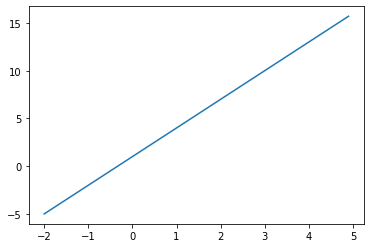

In [13]:
normalize = lambda x: (x-x.min())/(x.max()-x.min())
line = lambda x,p: p[0]+p[1]*x
x=np.arange(-2,5,0.1)
y=line(x,[1,3])
plt.plot(x,y)

### Task:

* Write a standard function that takes x, mu and sigma and returns a gaussian bell curve (with normalisation). Make sure that you use numpy operations only, so that you can give it a vector and receive a vector.<br> 
${\frac {1}{\sqrt {2\pi \sigma ^{2}}}}\operatorname {exp} \left(-{\frac {\left(x-\mu \right)^{2}}{2\sigma ^{2}}}\right)$
* plot this function with mu=0,sigma=1 from -5 to 5 in 0.01 steps 

* Write a lambda function that returns the normalized vector 
* use the cumsum function from numpy to create the cummulative sum of the gaussian from above and normalize it with your lambda function
* Plot this in the same plot (against x)
* What does this resemble?

# Parameter optimisation: Fitting vs. optimisation


## Curve Fit
Starting with curve_fit. We assume that we have a flat function that has a clear gradient to the minimum (see top of this page) then we can use curve_fit to fast measure the parameter we need

,values,errors
$\mu$,0.498208,0.005948
$\sigma$,0.499589,0.004856
$x_0$,0.049649,0.001995


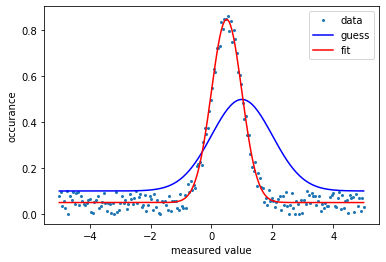

In [41]:
gauss = lambda x,mu=0,sigma=1,offset=0: 1/np.sqrt(2*np.pi*(sigma**2))*np.exp((-0.5/sigma**2)*(np.subtract(x,mu))**2)+offset
                                    
#create some data with some randomness and plot it
x=np.linspace(-5,5,200)
y=gauss(x,mu=0.5,sigma=0.5)+0.1*np.random.random(np.shape(x))
fig,ax=plt.subplots()
ax.plot(x,y,'o',ms=2,label='data')
ax.set_xlabel('measured value')
ax.set_ylabel('occurance')

from scipy.optimize import curve_fit
#make a guess
p0=[1,1,0.1]

#optimise
popt,pcov = curve_fit(gauss, xdata=x, ydata=y,p0=p0)

#plot both
ax.plot(x, gauss(x, mu=p0[0],sigma=p0[1],offset=p0[2]), 'b-', label='guess')
ax.plot(x, gauss(x, mu=popt[0],sigma=popt[1],offset=popt[2]), 'r-', label='fit')
ax.legend()


perr = np.sqrt(np.diag(pcov))
df=pd.DataFrame({'values':popt,'errors':perr},index=['$\mu$','$\sigma$','$x_0$'])
df=df[['values','errors']]
df

The key bit
```
from scipy.optimize import curve_fit
popt,pcov = curve_fit(gauss, xdata=x, ydata=y,p0=[1,0.5,0.1])
```
curve fit is a least square method that takes a function, the target data and a set of starting parameters, that are in order the parameter after the first.
it returns: 
popt = optimized parameter
and
pcov = covariance matrix.
p_sigma = np.sqrt(np.diag(pcov))


<div>
<img src="http://www.jensuhlig.de/Kemm30/KEMM30_009.jpg" width="400">
</div>

### Tasks:

Read the files, Fit files and plot both, data and fits:
* http://www.jensuhlig.de/Kemm30/fit_0.csv
* http://www.jensuhlig.de/Kemm30/fit_1.csv  here: try first a separate fit, in which you fit the linear range and then separately the peak.
* http://www.jensuhlig.de/Kemm30/fit_3.csv (two peaks and background)

## Scipy minimize

Second way of optimisation uses in addition to the "cost function" an "error function". The task of the second function is to create a "price" for this parameter. The Minimize function is then minimizing this price.

 final_simplex: (array([[0.50897668, 0.46933277, 0.33100131],
       [0.50898963, 0.46936711, 0.33100678],
       [0.50900159, 0.46933974, 0.33102792],
       [0.5088831 , 0.46934667, 0.33101213]]), array([1.36436863, 1.36436863, 1.36436874, 1.36436874]))
           fun: 1.3643686293870498
       message: 'Optimization terminated successfully.'
          nfev: 180
           nit: 99
        status: 0
       success: True
             x: array([0.50897668, 0.46933277, 0.33100131])


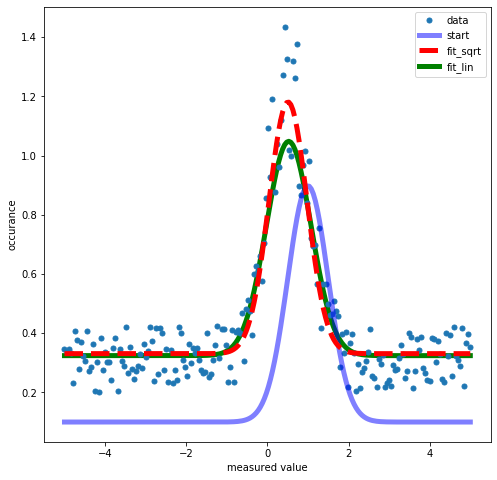

In [69]:
def gauss(x,p):
    [mu,sigma,offset]=p
    pre_factor=1/np.sqrt(2*np.pi*(sigma**2))
    exponent=(-0.5/sigma**2)*(np.subtract(x,mu))**2
    return pre_factor*np.exp(exponent)+offset

x=np.linspace(-5,5,200)
y=gauss(x,[0.5,0.5,0.2])
y=y+(y**0.5)*0.5*np.random.random(np.shape(x))
fig,ax=plt.subplots(figsize=(8,8))
ax.plot(x,y,'o',ms=5,label='data')
ax.set_xlabel('measured value')
ax.set_ylabel('occurance')

def min_gauss(p):# this would be the root mean square (we skip the root as the minimum is the minimum)
    return ((y-gauss(x,p))**2).sum()
def min_gauss_lin(p): #this is a different cost function that uses a more linear approach. It does not "punish" strong deviations as much. As such it has the tendency to be more outlier stable but preforms bad for peaks.
    return np.abs(y-gauss(x,p)).sum()

from scipy.optimize import minimize

x0=[1.,0.5,0.1]
out = minimize(min_gauss,x0=x0,method='Nelder-Mead') #nelder-Mead is a standard multi-parameter optimiser. check out other choices.
out2 = minimize(min_gauss_lin,x0=x0,method='Nelder-Mead')

ax.plot(x, gauss(x, p=x0), color='blue',lw=5,alpha=0.5,label='start')
ax.plot(x, gauss(x, p=out['x']), color='red',linestyle='dashed', lw=5,label='fit_sqrt')
ax.plot(x, gauss(x, p=out2['x']), color='green',lw=5,zorder=0, label='fit_lin')

print(out)
plt.legend()

### Task
use minimize with nelder mead and redo the fits from before.

Picture from 
http://www.esrf.eu/computing/Forum/imgCIF/PAPER/olivine.html
<div>
<img src="http://www.esrf.eu/computing/Forum/imgCIF/PAPER/olivine.jpg" width="400">
</div>
    
    

### Task
* cut this image to only have the powder rings (hint make it symmetric)
* convert the image into grey scale
* write the function of a small ring (two circles)
* make everything that is overlapping with the ring black
* optimise the parameter of the ring (middle point and diameter)
* repeat by adding more rings with the same central point but different diameter 
<br>
Hint:

In [11]:
image=np.array([['read and shape the image'],['2d']])
lx,ly=image.shape # measure the size of your image
X, Y = np.meshgrid(range(lx),range(ly))  #create for each point an information vector that splits x- and y coordinates
central_point=[350,650]
radius=[250,252]
mask=((X-central_point[0])**2+(Y-central_point[1])**2 > radius[0]**2) 


make a mask where everything that is larger tha the radius true is

In [12]:
mask=((X-central_point[0])**2+(Y-central_point[1])**2 > radius[0]**2) 

make a second mask for the second radius and combine them with a logical operation (add / or) and put them into a function>

In [13]:
def combined_mask(dimensions,central_point,radius1,radius2):
    mask='some operations'
    return mask

In [16]:
image[combined_mask(dimensions=None,central_point=None,radius1=None,radius2=None)]=0

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices